# Seleção de Atributos (PORTUGUÊS)
Objetivo: Avaliar os atributos mais relevantes para o desempenho acadêmico utilizando testes estatísticos e regressões com base nos módulos existentes.

###### ajustar o path

In [70]:
# HIDE
import sys
import pathlib

path = pathlib.Path().resolve()
while path.name != 'student_perfomance_tcc' and path != path.parent:
    path = path.parent

# Adicionar a raiz ao sys.path para importar o módulo
if str(path) not in sys.path:
    sys.path.append(str(path))

from ajustar_path import adicionar_modulos_ao_path

# Adiciona a pasta 'modulos' ao path
adicionar_modulos_ao_path()

## Importações e Configurações Iniciais

In [71]:
#Importação dos módulos desenvolvidos

from pre_modelagem import *
from eda_functions import *
from feature_selection import *

# Bibliotecas

import pandas as pd
import numpy as np



from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split


from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestRegressor
import shap



import seaborn as sns
import matplotlib.pyplot as plt

import warnings

# Ignora todos os warnings
warnings.filterwarnings('ignore')


# 1. Importação da Base e Pré-Modelagem

In [72]:
#Import base

materia =  'portugues' 

cor_paleta = 'azul' 

df = importar_base(materia)

df_original = df.copy() 

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   escola                        649 non-null    object
 1   genero                        649 non-null    object
 2   idade                         649 non-null    int64 
 3   endereco                      649 non-null    object
 4   tamanho_familia               649 non-null    object
 5   status_parental               649 non-null    object
 6   escolaridade_mae              649 non-null    int64 
 7   escolaridade_pai              649 non-null    int64 
 8   profissao_mae                 649 non-null    object
 9   profissao_pai                 649 non-null    object
 10  motivo_escolha_escola         649 non-null    object
 11  responsavel_legal             649 non-null    object
 12  tempo_transporte              649 non-null    int64 
 13  tempo_estudo        

# 2. Síntese dos resultados EDA


 - As notas apresentaram distribuições não normais segundo Shapiro-Wilk
 - Algumas variáveis categóricas demonstraram associação com aprovação
 - Multicolinearidade ainda será avaliada neste notebook


## 3. Avaliação de multicolinearidade
- Análise de VIF e correlação para identificar redundâncias entre as variáveis.

In [74]:
df_pp = preparar_dados(df, columns_to_drop=['aprovacao'])

Removendo colunas: ['aprovacao']
Shape final do DataFrame preparado: (649, 42)


In [75]:
# Remove variáveis-alvo antes da análise de VIF/correlação entre preditores
variaveis_target = ['nota1', 'nota2', 'nota_final']
df_preditores = df_pp.drop(columns=variaveis_target)


print('limiar coeficiente de correlação > 0.6')
resumo, vif_df =  relatorio_multicolinearidade(df_preditores,limite_corr=0.6)
    
display(resumo[resumo['avaliacao'] != 'Sem alerta'])


limiar coeficiente de correlação > 0.6


,variavel_1,variavel_2,correlacao
5,escolaridade_pai,escolaridade_mae,0.647477
189,alcool_fim_semana,alcool_dias_uteis,0.616561
526,profissao_pai_Serviços,profissao_pai_Outra profissão,0.709455


,variavel,vif,Alta correlação com,avaliacao
0,idade,75.700824,—,VIF elevado
15,relacao_familiar,19.645464,—,VIF elevado
2,escolaridade_mae,15.864643,escolaridade_pai,VIF alto + correlação alta
16,tempo_livre,12.357453,—,VIF elevado
17,frequencia_saidas,12.081671,—,VIF elevado
12,interesse_ensino_superior,11.333853,—,VIF elevado
3,escolaridade_pai,11.308704,escolaridade_mae,VIF alto + correlação alta
30,profissao_pai_Outra profissão,10.350741,profissao_pai_Serviços,VIF alto + correlação alta
19,alcool_fim_semana,8.724827,alcool_dias_uteis,VIF alto + correlação alta
5,tempo_estudo,7.879912,—,VIF elevado


In [76]:
variaveis_alta_colineariedade = [
            #'escolaridade_mae',
            'escolaridade_pai',
            'alcool_fim_semana',
            #'alcool_dias_uteis',
            'profissao_pai_Outra profissão',
            'profissao_pai_Serviços'
        ]

In [77]:
corr = df_pp[variaveis_alta_colineariedade + variaveis_target].corr()

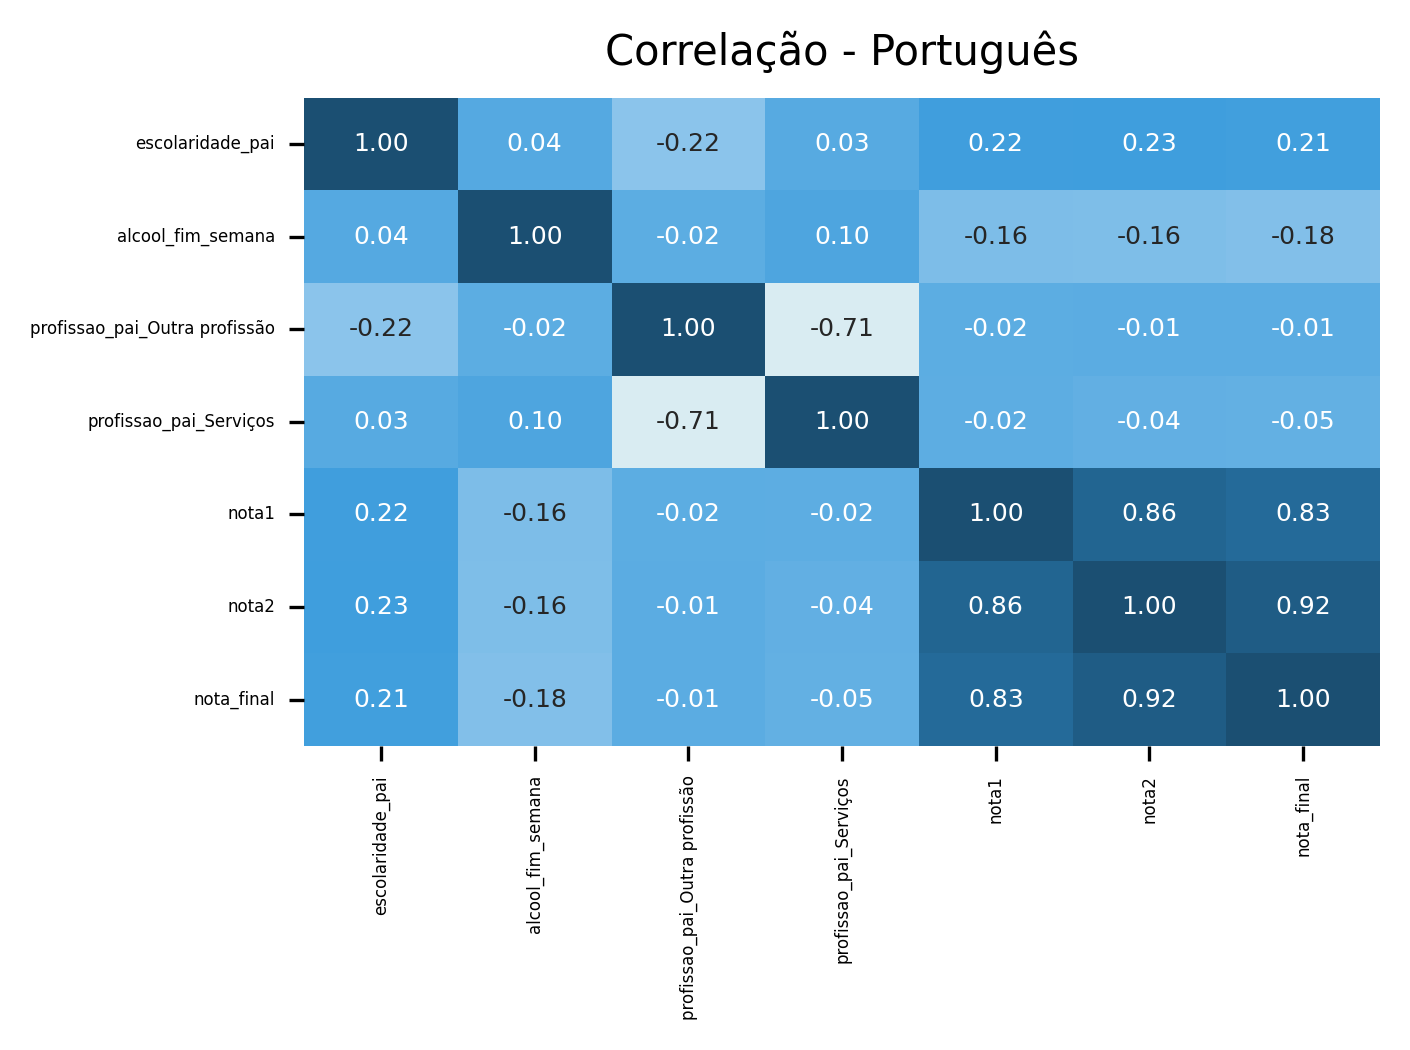

In [78]:
custom_heatmap(disciplina=materia,cores=cor_paleta,matriz_corr=corr, n_arq='corr_multicol',titulo='Correlação')

# 4. Análise da Relação entre Nota 1 e Nota 2

**REGRESSÃO NOTAS**


## 4.1. Modelo simples (nota1)
- Objetivo: Verificar a relação direta entre nota1 e nota2.
- Avaliar o comportamento dos coeficientes e resíduos.

In [79]:
#Pré processamento

df_pp = preparar_dados(df, columns_to_drop=['aprovacao','nota_final'],target_column='nota2')

Removendo colunas: ['aprovacao', 'nota_final']
Shape final do DataFrame preparado: (649, 41)


In [80]:
modelo_n2_1 = regressao_multipla(df_pp, target='nota2', variaveis=['nota1'])

print(modelo_n2_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  nota2   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     1922.
Date:                Sat, 10 May 2025   Prob (F-statistic):          6.37e-196
Time:                        03:41:18   Log-Likelihood:                -1166.9
No. Observations:                 649   AIC:                             2338.
Df Residuals:                     647   BIC:                             2347.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1054      0.245      4.503      0.0

## 4.2. Regressão múltipla com nota1 e variáveis adicionais
- Objetivo: Avaliar estabilidade dos coeficientes da nota1 e identificar covariáveis explicativas para nota2.

**Regressão sem selecao de atributos**

In [81]:
aux_drop = ['nota2']

variaveis_1 = list(set(df_pp.columns) - set(aux_drop))

modelo_n2_2 = regressao_multipla(df_pp, target='nota2',variaveis=variaveis_1)

**Identificando os menores pvalores do sumário** 

In [82]:
_ , top_15_var = ajustar_regressao(
                                df=df_pp,
                                target_column='nota2',
                                top_n =15    
                              )   

--- Sumário do Modelo de Regressão OLS ---
                            OLS Regression Results                            
Dep. Variable:                  nota2   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     50.27
Date:                Sat, 10 May 2025   Prob (F-statistic):          2.47e-165
Time:                        03:41:18   Log-Likelihood:                -1140.6
No. Observations:                 649   AIC:                             2363.
Df Residuals:                     608   BIC:                             2547.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

,Coef.,Std.Err.,t,P>|t|
nota1,0.864,0.026,33.219,9.17e-139
idade,0.190,0.056,3.416,0.001
reprovacoes,-0.364,0.114,-3.194,0.001
relacao_familiar,0.161,0.063,2.548,0.011
saude,-0.087,0.042,-2.065,0.039
relacionamento_romantico,-0.255,0.125,-2.043,0.041
interesse_ensino_superior,0.253,0.212,1.197,0.232
profissao_pai_Serviços,-0.271,0.261,-1.038,0.3
aulas_particulares,0.254,0.251,1.011,0.312
frequencia_saidas,-0.058,0.058,-0.992,0.321


-----------------------------------------------

Atributos de maior relevância (por P-valor):
1. nota1
2. idade
3. reprovacoes
4. relacao_familiar
5. saude
6. relacionamento_romantico
7. interesse_ensino_superior
8. profissao_pai_Serviços
9. aulas_particulares
10. frequencia_saidas
11. motivo_escolha_escola_Outro motivo
12. profissao_mae_Professor(a)
13. acesso_internet
14. escolaridade_pai
15. endereco_Urbano


In [83]:
top_15_var

['nota1',
 'idade',
 'reprovacoes',
 'relacao_familiar',
 'saude',
 'relacionamento_romantico',
 'interesse_ensino_superior',
 'profissao_pai_Serviços',
 'aulas_particulares',
 'frequencia_saidas',
 'motivo_escolha_escola_Outro motivo',
 'profissao_mae_Professor(a)',
 'acesso_internet',
 'escolaridade_pai',
 'endereco_Urbano']

In [84]:
aux = ['nota2']

variaveis_1 = top_15_var

modelo_n2_3 = regressao_multipla(df_pp[variaveis_1 + aux], 
                                 target='nota2',variaveis=variaveis_1)


**extraindo atributos com multicolineariedade elevada**

In [85]:
aux = list(set(top_15_var) & set(variaveis_alta_colineariedade))
aux

['escolaridade_pai', 'profissao_pai_Serviços']

In [86]:
aux_drop = ['nota2','profissao_pai_Outra profissão']

variaveis_1 = list(set(top_15_var) - set(aux_drop))

modelo_n2_4 = regressao_multipla(df_pp[variaveis_1+['nota2']],
                               target='nota2', variaveis=variaveis_1)


In [87]:
aux_drop = ['nota2','profissao_pai_Outra profissão']

variaveis_1 = list(set(top_15_var) - set(aux_drop))
#incluindo faltas
modelo_n2_5 = regressao_multipla(df_pp[variaveis_1+['nota2','faltas']],
                               target='nota2', variaveis=variaveis_1)

**stepwise_selection** - AIC e BIC

In [88]:
variaveis_sem_nota = df_pp.drop(columns='nota2').columns


features_bic = stepwise_selection(
    df=df_pp,
    target='nota2',
    variaveis_candidatas=variaveis_sem_nota,
    criterion='aic', 
    verbose=True 
)

features_aic = stepwise_selection(
    df=df_pp,
    target='nota2',
    variaveis_candidatas=variaveis_sem_nota,
    criterion='bic', # Escolhendo BIC
    verbose=True 
)


from itertools import chain

seen = set()
features_all = []    
for item in chain(*[features_aic,features_bic]):
    if item not in seen:
        seen.add(item)
        features_all.append(item)

features_all

Critério inicial (AIC): 3230.8661


Adicionada: nota1 (AIC=2337.8346)
Adicionada: reprovacoes (AIC=2331.1390)
Adicionada: idade (AIC=2322.7072)
Adicionada: relacao_familiar (AIC=2319.3893)
Adicionada: saude (AIC=2317.0038)
Adicionada: relacionamento_romantico (AIC=2314.6177)
Adicionada: escolaridade_mae (AIC=2312.5250)
Adicionada: frequencia_saidas (AIC=2312.2812)
Adicionada: profissao_pai_Serviços (AIC=2312.1365)

Variáveis selecionadas final (aic): ['nota1', 'reprovacoes', 'idade', 'relacao_familiar', 'saude', 'relacionamento_romantico', 'escolaridade_mae', 'frequencia_saidas', 'profissao_pai_Serviços']
Critério inicial (BIC): 3235.3416
Adicionada: nota1 (BIC=2346.7855)
Adicionada: reprovacoes (BIC=2344.5653)
Adicionada: idade (BIC=2340.6090)

Variáveis selecionadas final (bic): ['nota1', 'reprovacoes', 'idade']


['nota1',
 'reprovacoes',
 'idade',
 'relacao_familiar',
 'saude',
 'relacionamento_romantico',
 'escolaridade_mae',
 'frequencia_saidas',
 'profissao_pai_Serviços']

In [89]:
modelo_step = regressao_multipla(df_pp[features_all+['nota2']],target='nota2', variaveis=features_all)
print(modelo_step.summary())

                            OLS Regression Results                            
Dep. Variable:                  nota2   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     229.7
Date:                Sat, 10 May 2025   Prob (F-statistic):          1.07e-193
Time:                        03:41:19   Log-Likelihood:                -1146.1
No. Observations:                 649   AIC:                             2312.
Df Residuals:                     639   BIC:                             2357.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

## 4.3 Importância dos atributos com SHAP (Random Forest Regressor)


In [90]:
comparar_modelos_regressao(
    modelos=[modelo_n2_1, modelo_n2_2, modelo_n2_3, modelo_n2_4, modelo_n2_5, modelo_step],
    nomes=['Modelo 1', 'Modelo 2', 'Modelo 3', 'Modelo 4', 'Modelo 5', 'Modelo Step']
)

,Modelo,R²,R² Ajustado,AIC,BIC,Log-Likelihood,F-statistic,RMSE,Variáveis Significantes
0,Modelo 1,0.748193,0.747804,2337.834640,2346.785506,-1166.917320,1922.430426,1.463204,2
1,Modelo 2,0.767824,0.752549,2363.157305,2546.650046,-1140.578653,50.267615,1.449372,6
2,Modelo 3,0.765819,0.760270,2318.737986,2390.344909,-1143.368993,138.002549,1.426583,7
3,Modelo 4,0.765819,0.760270,2318.737986,2390.344909,-1143.368993,138.002549,1.426583,7
4,Modelo 5,0.765819,0.760270,2318.737986,2390.344909,-1143.368993,138.002549,1.426583,7
5,Modelo Step,0.763863,0.760537,2312.136476,2356.890803,-1146.068238,229.672905,1.425787,7


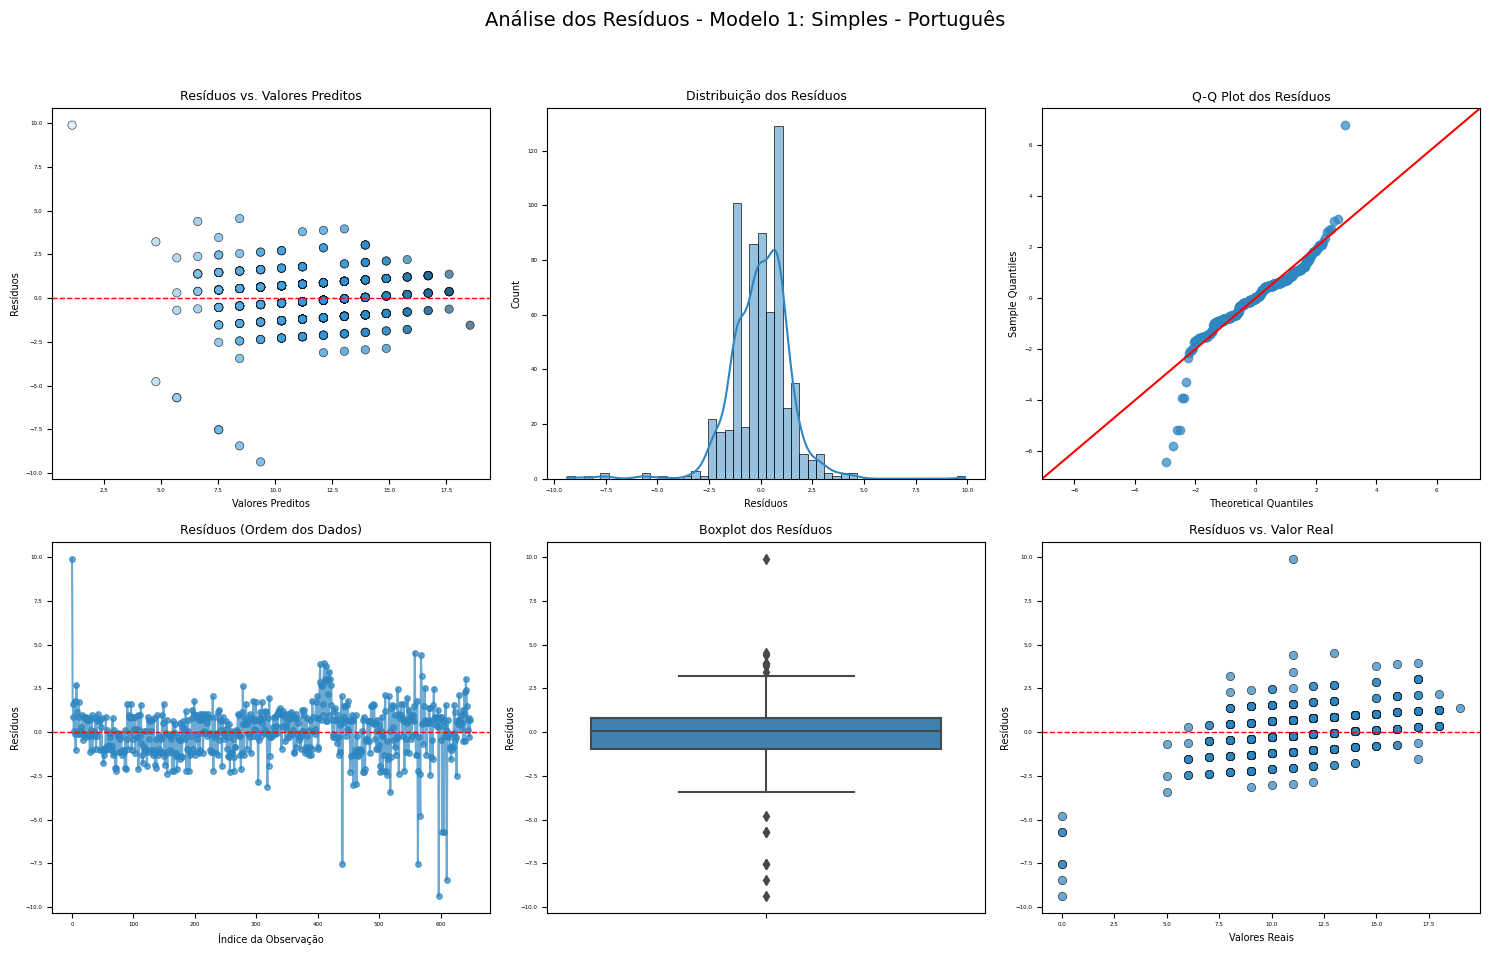

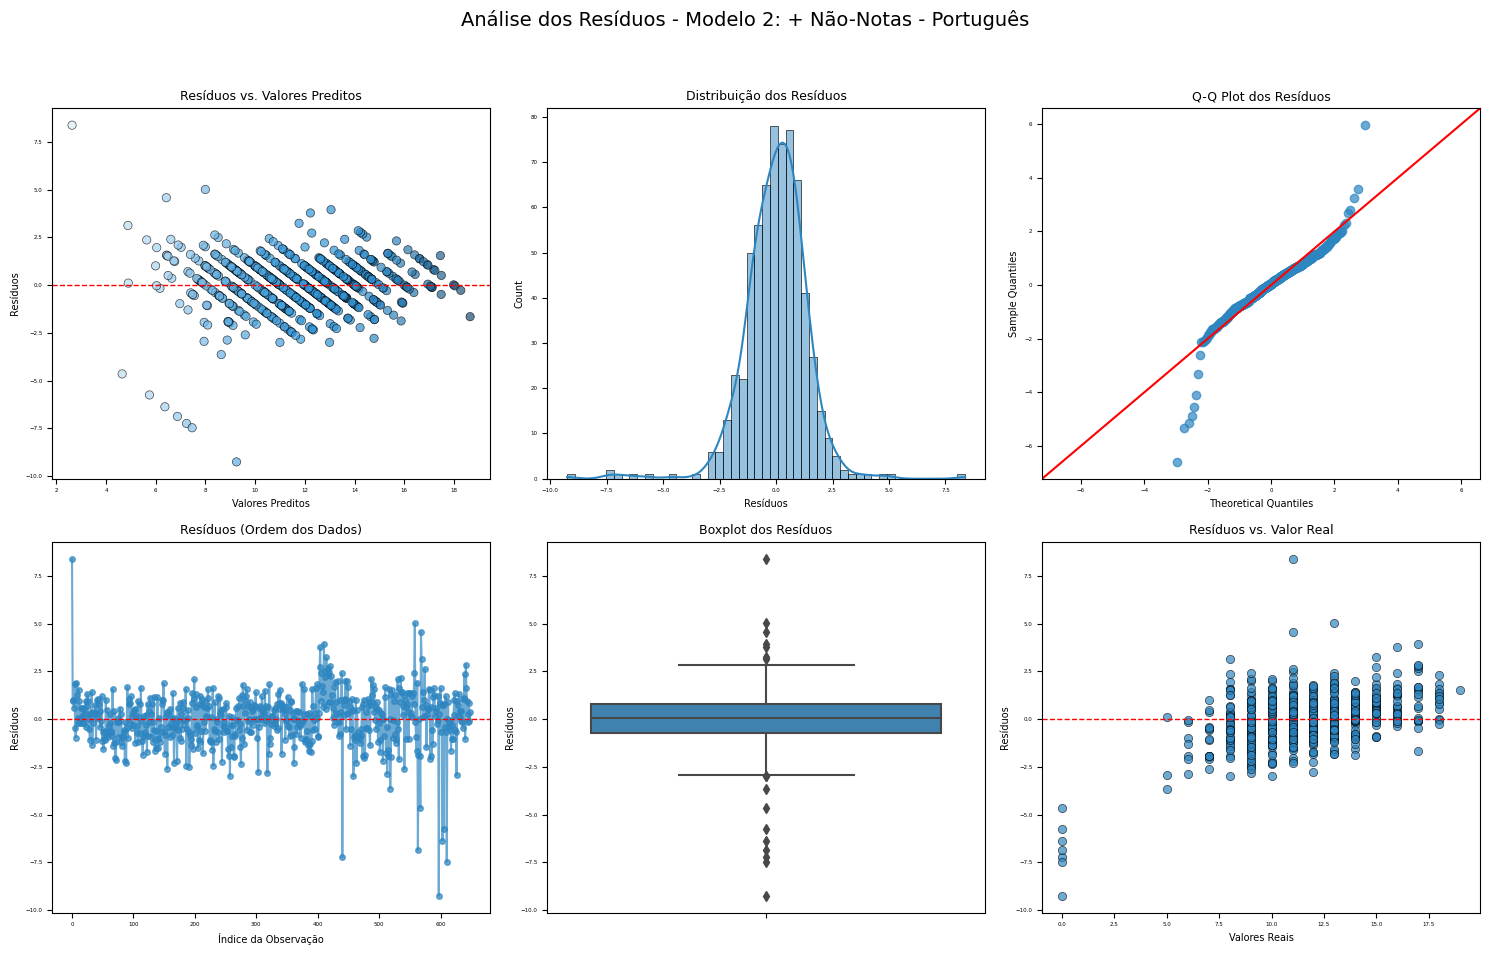

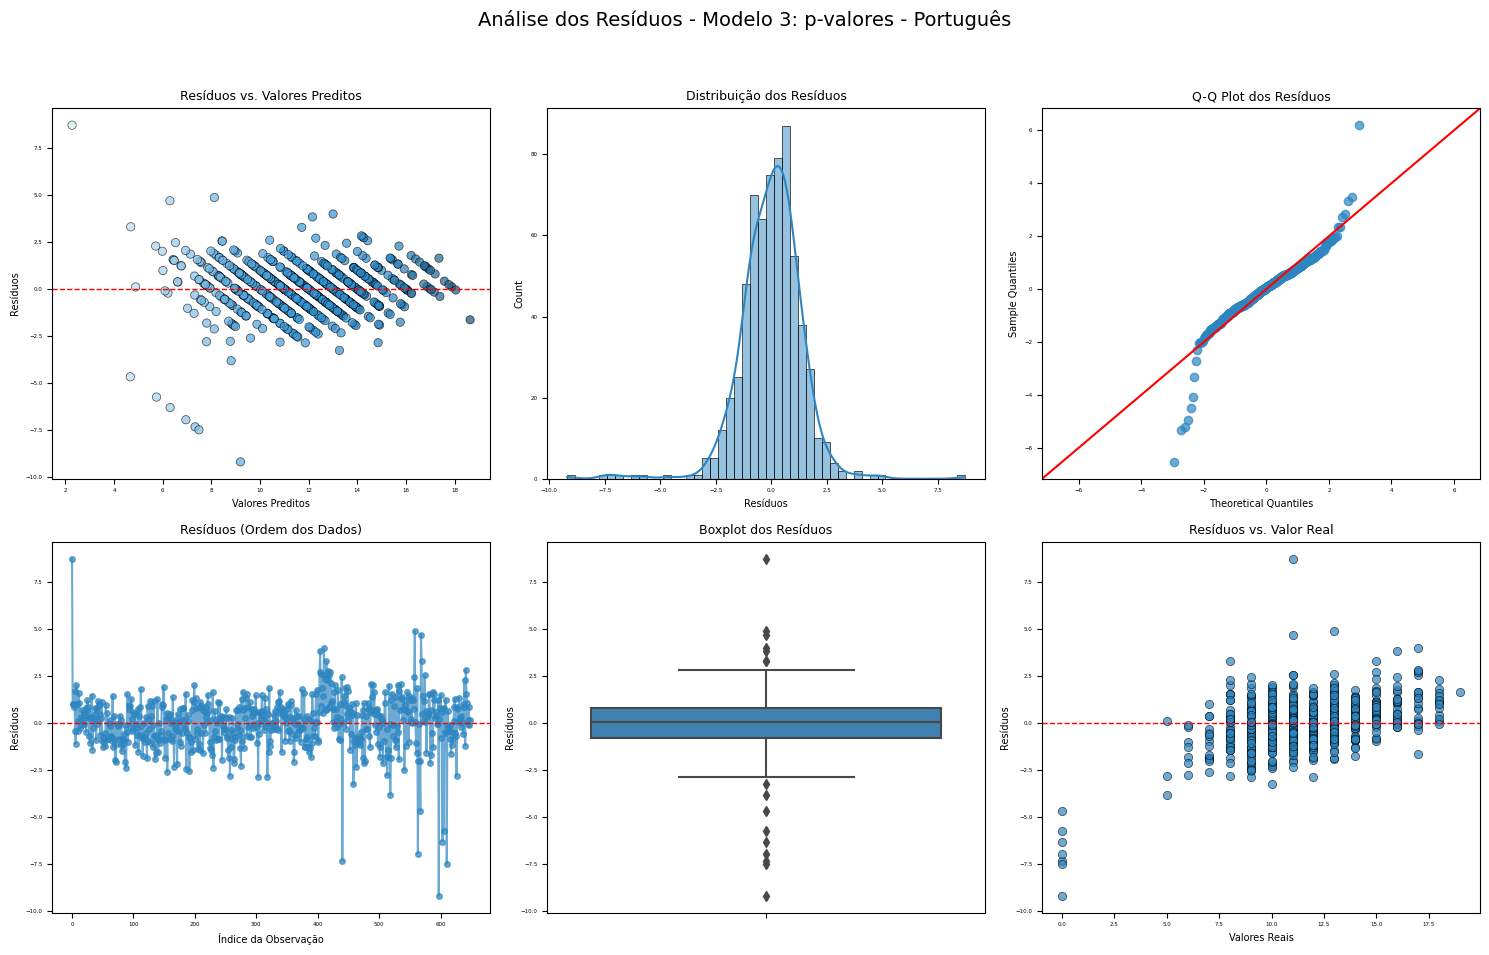

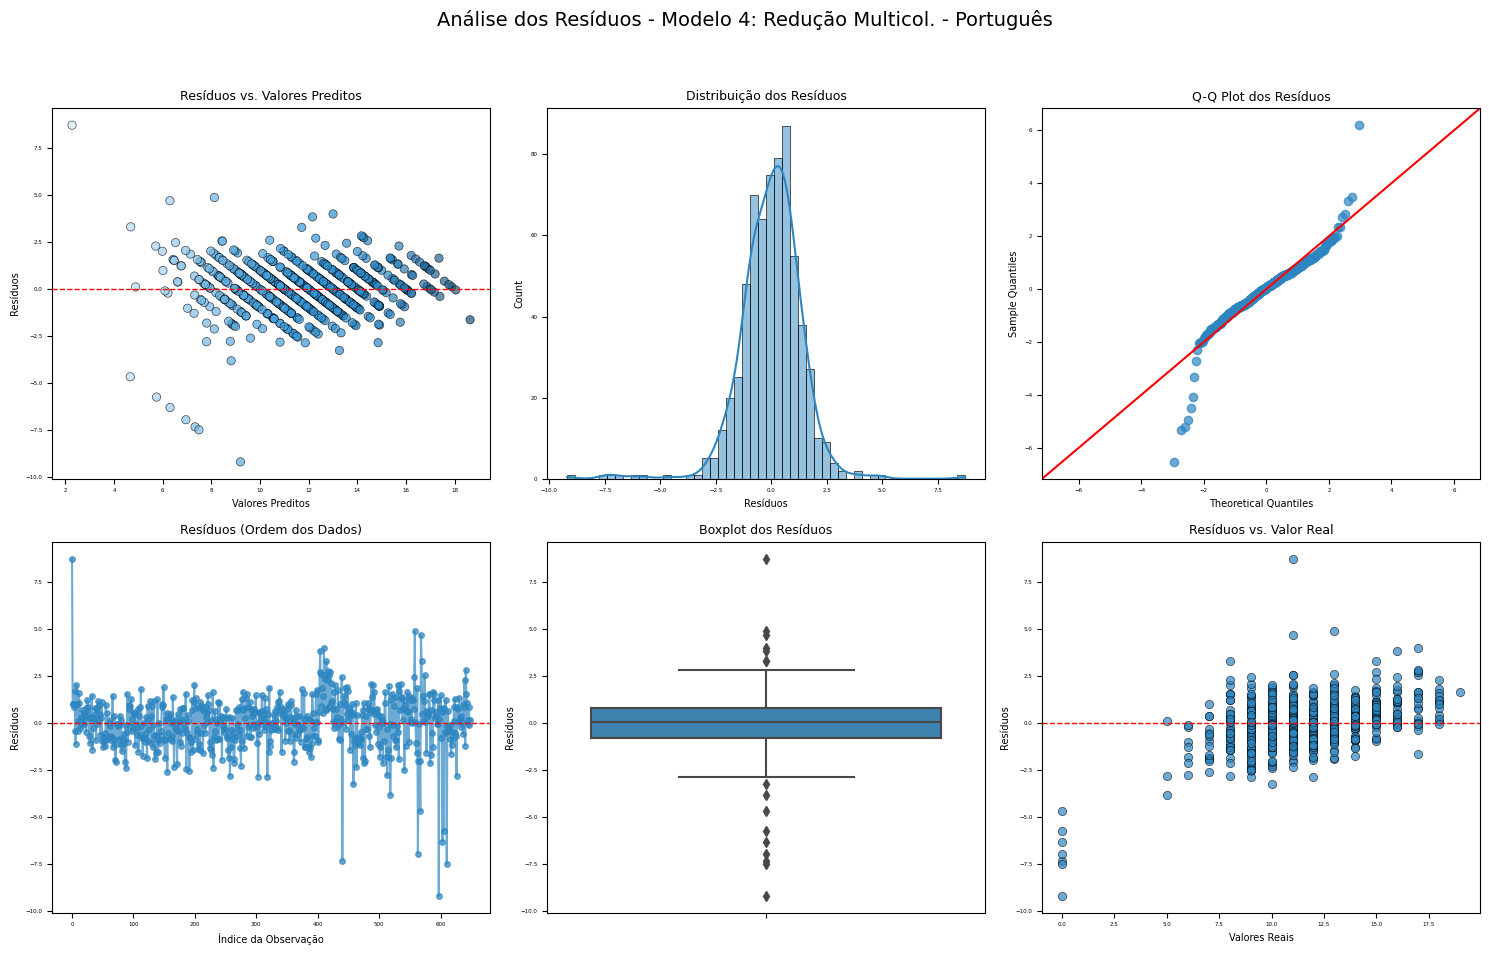

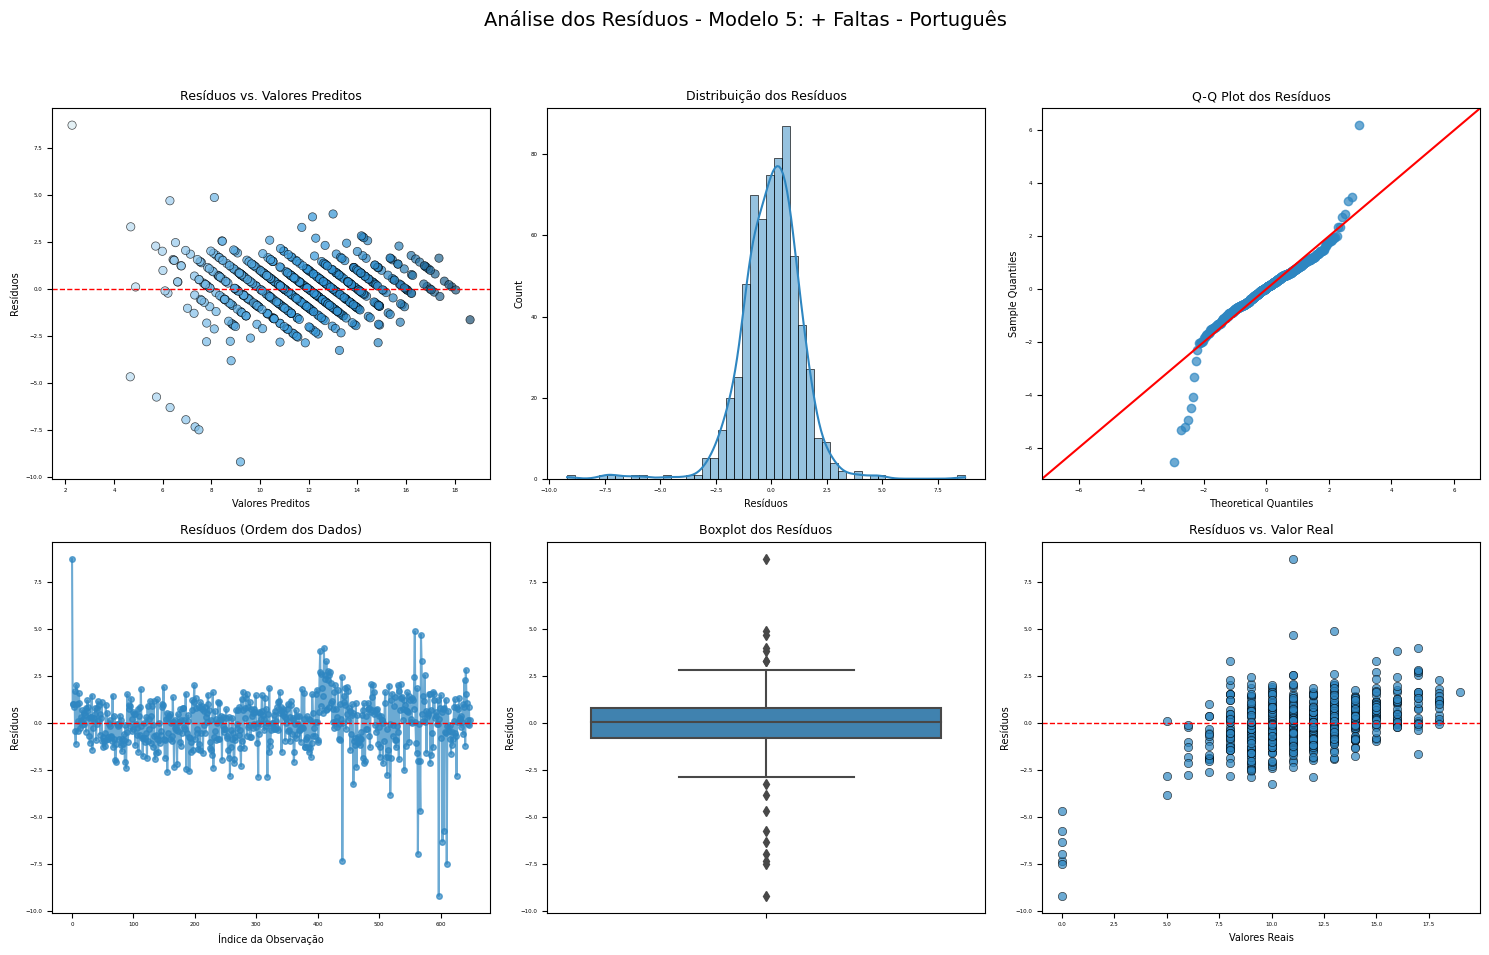

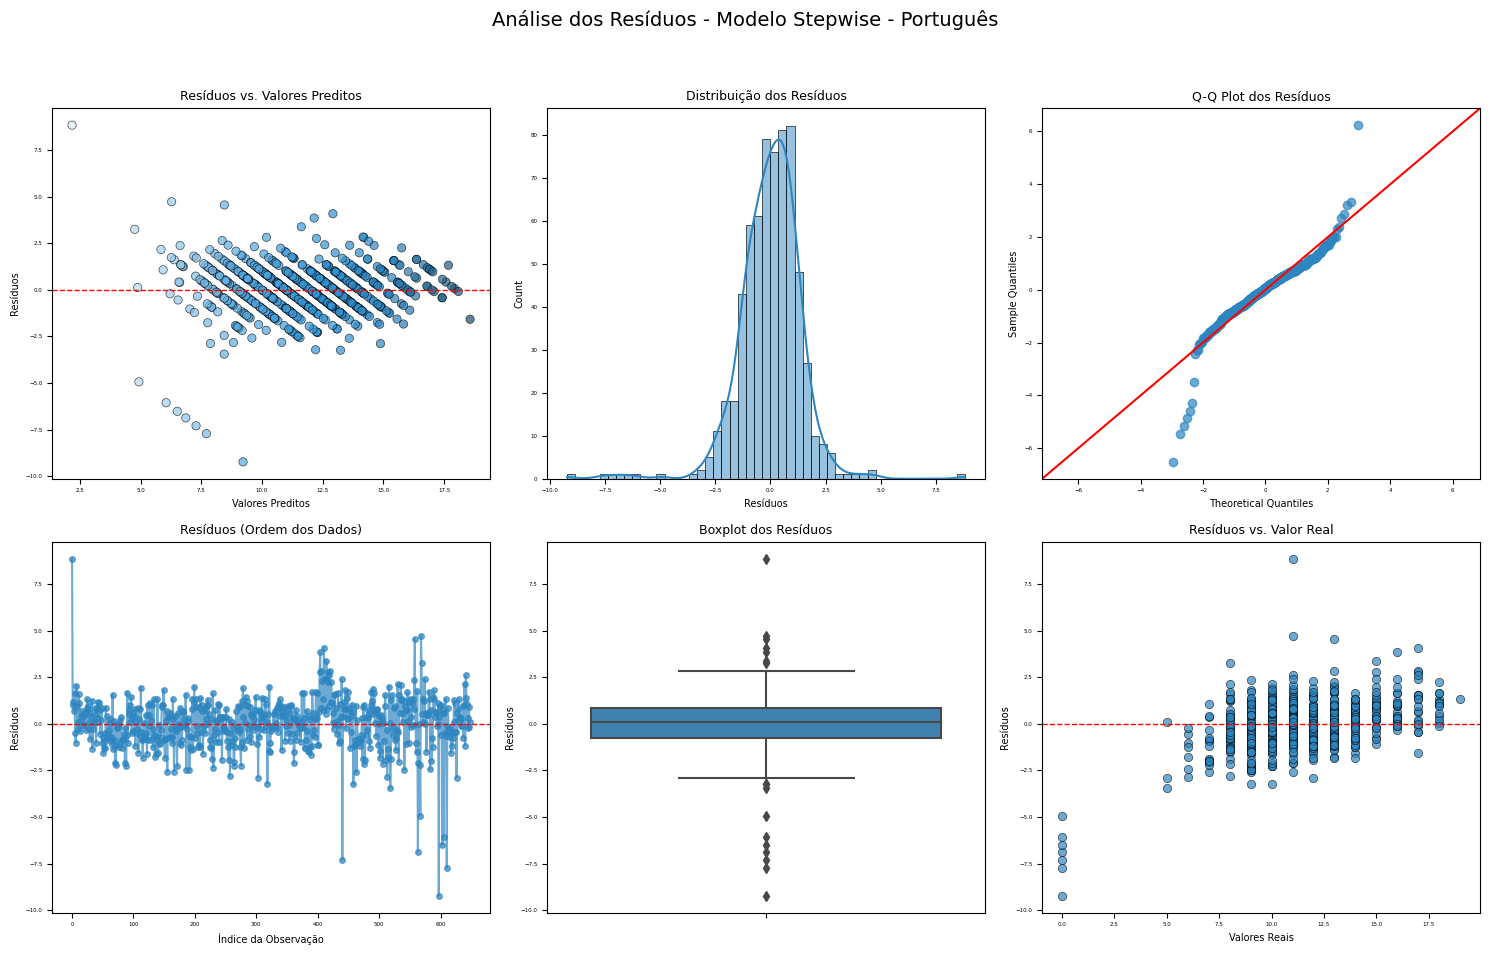

,Modelo,Média dos Resíduos,Shapiro-Wilk Estatística,Shapiro-Wilk P-valor,Normalidade (Shapiro-Wilk > 0.05),Breusch-Pagan (LM) P-valor,Homoscedasticidade (BP > 0.05),Durbin-Watson Estatística,Autocorrelação (DW ≈ 2),Outliers (|z| > 3)
0,Modelo 1: Simples,0.0,0.8954,0.0,Não,0.0,Não,1.6694,Ausente (aprox.),10
1,Modelo 2: + Não-Notas,0.0,0.9080,0.0,Não,0.0,Não,1.7828,Ausente (aprox.),10
2,Modelo 3: p-valores,0.0,0.9060,0.0,Não,0.0,Não,1.7654,Ausente (aprox.),10
3,Modelo 4: Redução Multicol.,-0.0,0.9060,0.0,Não,0.0,Não,1.7654,Ausente (aprox.),10
4,Modelo 5: + Faltas,-0.0,0.9060,0.0,Não,0.0,Não,1.7654,Ausente (aprox.),10
5,Modelo Stepwise,0.0,0.9019,0.0,Não,0.0,Não,1.7642,Ausente (aprox.),10


In [91]:
resultados_residuos = []

resultados_residuos.append(avaliar_residuos_regressao(df['nota2'], modelo_n2_1.predict(), 'Modelo 1: Simples', materia))
resultados_residuos.append(avaliar_residuos_regressao(df['nota2'], modelo_n2_2.predict(), 'Modelo 2: + Não-Notas', materia))
resultados_residuos.append(avaliar_residuos_regressao(df['nota2'], modelo_n2_3.predict(), 'Modelo 3: p-valores', materia))
resultados_residuos.append(avaliar_residuos_regressao(df['nota2'], modelo_n2_4.predict(), 'Modelo 4: Redução Multicol.', materia))
resultados_residuos.append(avaliar_residuos_regressao(df['nota2'], modelo_n2_5.predict(), 'Modelo 5: + Faltas', materia))
resultados_residuos.append(avaliar_residuos_regressao(df['nota2'], modelo_step.predict(), 'Modelo Stepwise', materia))

df_residuos = pd.DataFrame(resultados_residuos)
df_residuos

## 4.4 Importância com SHAP (Random Forest Regressor)


In [92]:
y = df_pp['nota2']
X = df_pp.drop(columns=['nota2'])

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [94]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Text(0.5, 1.0, 'Importância das variáveis - Treinamento')

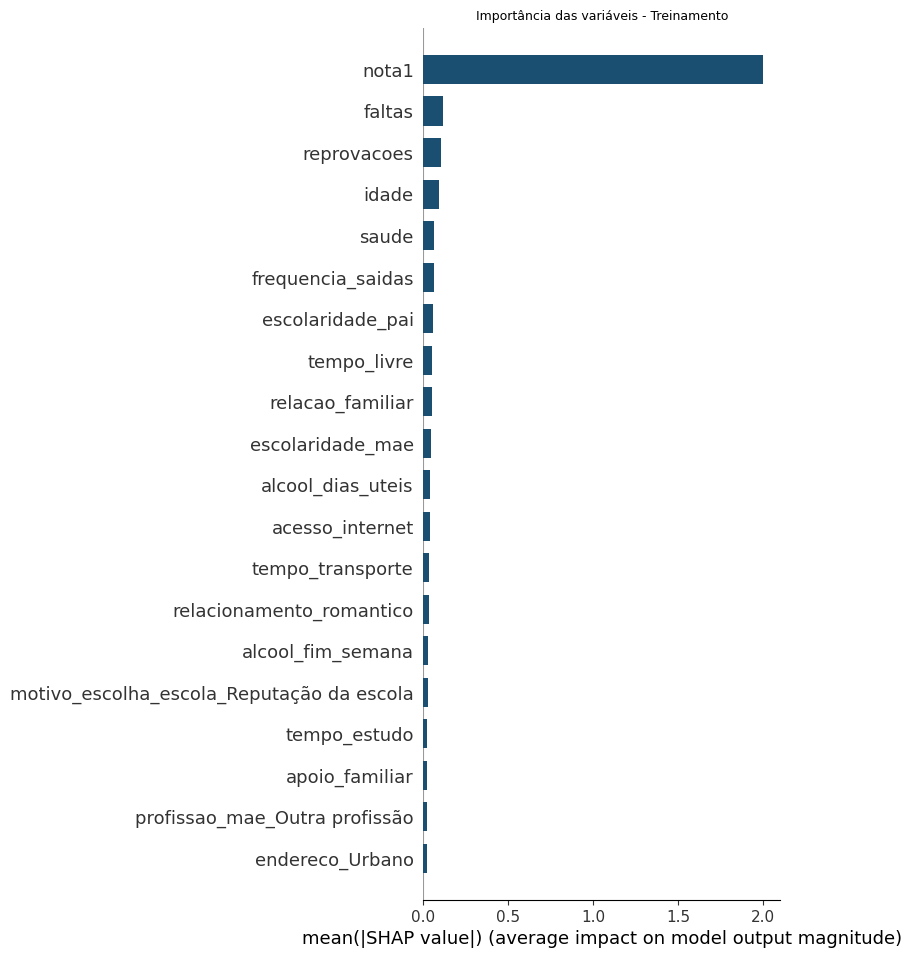

In [95]:
#Calcular os explainer -
explainer = shap.Explainer(model, X_train)
shap_values_train = explainer(X_train)
shap.summary_plot(shap_values_train, X_train, plot_type="bar",show=False, color='#1B4F72')
plt.title('Importância das variáveis - Treinamento')


# 5. Análise dos Fatores Associados à Nota Final

- Objetivo: Investigar a contribuição de fatores socioeconômicos e escolares na nota final.

In [96]:
df_pp = preparar_dados(df, columns_to_drop=['aprovacao','nota1','nota2'],target_column='nota_final') 

Removendo colunas: ['aprovacao', 'nota1', 'nota2']
Shape final do DataFrame preparado: (649, 40)


## 5.4 Importância com SHAP (Random Forest Regressor)

Nesta etapa, utilizamos o SHAP (SHapley Additive Explanations) com um modelo Random Forest Regressor para identificar as variáveis com maior impacto na previsão da nota final.
A análise é realizada sobre o conjunto de treino, com foco em interpretar o que o modelo aprendeu sobre os fatores determinantes do desempenho geral dos alunos.

In [97]:
y = df_pp['nota_final']
X = df_pp.drop(columns=['nota_final'])

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [99]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Text(0.5, 1.0, 'Importância das variáveis - Treinamento - Português')

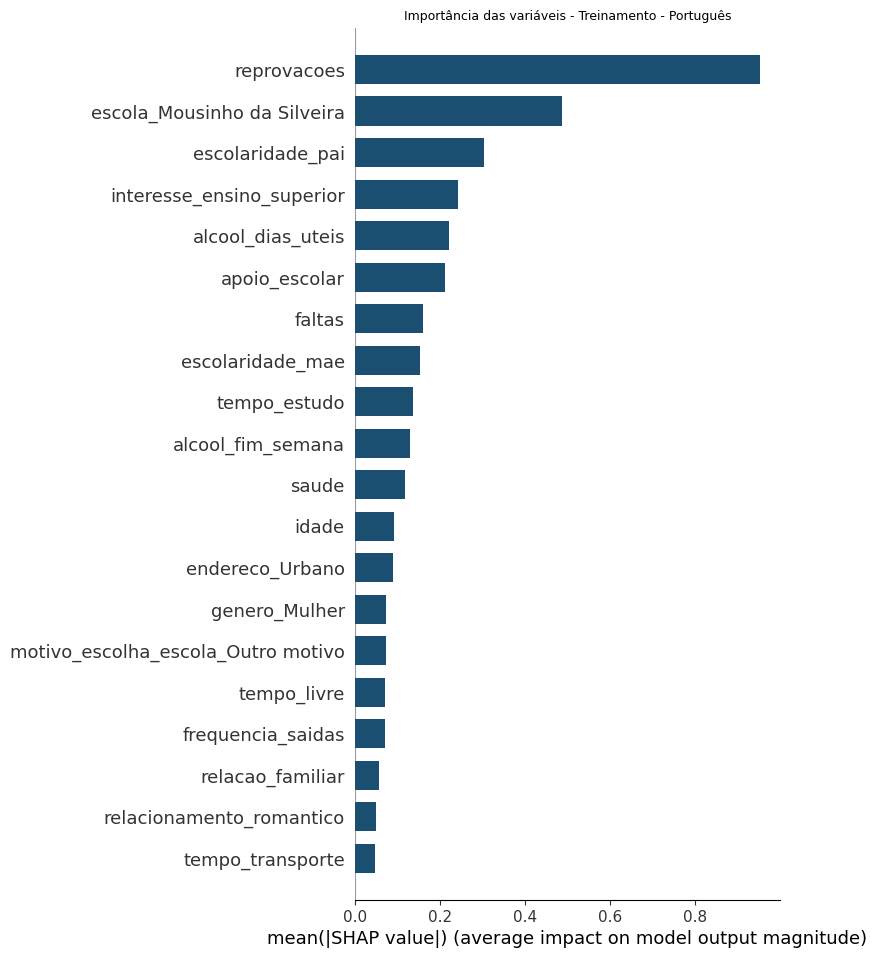

In [100]:
#Calcular os explainer -
explainer = shap.Explainer(model, X_train)
shap_values_train = explainer(X_train)
shap.summary_plot(shap_values_train, X_train, plot_type="bar",show=False, color='#1B4F72')
plt.title('Importância das variáveis - Treinamento - Português')


# 6. Testes estatísticos para seleção de atributos

In [101]:
variaveis_categoricas_nominais = [
    'escola', 
    'genero', 
    'endereco', 
    'status_parental', 
    'profissao_mae', 
    'profissao_pai', 
    'motivo_escolha_escola', 
    'responsavel_legal', 
    'apoio_escolar', 
    'apoio_familiar', 
    'aulas_particulares', 
    'atividades_extracurriculares', 
    'frequentou_creche', 
    'interesse_ensino_superior', 
    'acesso_internet', 
    'relacionamento_romantico',
    'tamanho_familia',

    ]

variaveis_categoricas_ordinais = [
    'escolaridade_mae', 
    'escolaridade_pai', 
    'relacao_familiar',
    'tempo_livre',      
    'frequencia_saidas',
    'saude',            
    'tempo_estudo',     
    'tempo_transporte',
    'alcool_dias_uteis',
    'alcool_fim_semana',
    'reprovacoes' 

    ]

variaveis_categoricas = variaveis_categoricas_nominais + variaveis_categoricas_ordinais


## 6.1. Testes para variáveis ordinais
- Aplicação de testes não paramétricos para avaliar associação com desempenho.

In [102]:
print('Português - Variáveis Categóricas ordinais \n')
df_ord = selecionar_ordinais_relevantes(df, variaveis_categoricas_ordinais, target='nota_final')


Português - Variáveis Categóricas ordinais 

Variáveis ordinais relevantes para explicabilidade do atributo 'nota_final'
  com base nos testes estatísticos:


,Variável,Correlação (Spearman),P-valor (Spearman),Estatística H (Kruskal),P-valor (Kruskal)
10,reprovacoes,-0.448,2.05e-33,130.659,3.90e-28
0,escolaridade_mae,0.284,1.69e-13,57.215,1.12e-11
6,tempo_estudo,0.275,1.06e-12,50.316,6.84e-11
1,escolaridade_pai,0.235,1.44e-09,36.785,1.99e-07
8,alcool_dias_uteis,-0.208,8.43e-08,29.665,5.73e-06
9,alcool_fim_semana,-0.171,1.20e-05,24.297,6.96e-05
7,tempo_transporte,-0.147,0.0,14.751,0.002
3,tempo_livre,-0.128,0.001,19.546,0.001
5,saude,-0.106,0.007,10.997,0.027
4,frequencia_saidas,-0.105,0.007,19.766,0.001



## 6.2. Testes para variáveis nominais
- Aplicação de testes de independência para verificar significância de categorias nominais.

### 6.2.1 Aplicação nas variáveis nominais antes do onehotencoding

In [103]:
print('Português - Variáveis Categóricas Nominais \n')

df_nom =selecionar_nominais_relevantes(df, categoria_de_interesse='aprovacao', variaveis_categoricas=variaveis_categoricas,c_c=0)

Português - Variáveis Categóricas Nominais 

Variáveis com P-Value < 0.05 e V de Cramér > 0.00:


,Variable,P-Value,V de Cramér
14,reprovacoes,1.05e-22,0.403
4,interesse_ensino_superior,1.22e-14,0.303
0,escola,8.81e-14,0.293
7,escolaridade_pai,8.16e-05,0.192
6,escolaridade_mae,0.0,0.178
8,relacao_familiar,0.001,0.172
11,tempo_estudo,0.0,0.172
3,motivo_escolha_escola,0.0,0.166
10,frequencia_saidas,0.002,0.161
12,alcool_dias_uteis,0.019,0.135


### 6.2.1 Aplicação nas variáveis nominais após do onehotencoding

In [104]:
df_p = preparar_dados(df,'aprovacao',columns_to_drop=['nota1','nota2','nota_final'])

Removendo colunas: ['nota1', 'nota2', 'nota_final']
Shape final do DataFrame preparado: (649, 40)


In [105]:
v_c = pd.get_dummies(
    df[list(set(variaveis_categoricas_nominais) - {'aprovacao'})],
    drop_first=False
).columns.tolist()


variaveis_dummies_nominais = [col for col in df_p.columns if col in v_c]


In [106]:
variaveis_dummies_nominais

['escola_Mousinho da Silveira',
 'genero_Mulher',
 'endereco_Urbano',
 'status_parental_Separados',
 'profissao_mae_Outra profissão',
 'profissao_mae_Professor(a)',
 'profissao_mae_Serviços',
 'profissao_mae_Área da saúde',
 'profissao_pai_Outra profissão',
 'profissao_pai_Professor(a)',
 'profissao_pai_Serviços',
 'profissao_pai_Área da saúde',
 'motivo_escolha_escola_Outro motivo',
 'motivo_escolha_escola_Próximo de casa',
 'motivo_escolha_escola_Reputação da escola',
 'responsavel_legal_Outro responsável',
 'responsavel_legal_Pai']

In [107]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2

# 1. Seleção das variáveis categóricas binárias (sem vírgula!)
X_cat_bin_only = df_p[variaveis_dummies_nominais]

# 2. Aplicar SelectKBest com chi2
selector_chi2 = SelectKBest(score_func=chi2, k='all')
selector_chi2.fit(X_cat_bin_only, y=df_p['aprovacao'])

# 3. Obter resultados
scores = selector_chi2.scores_
p_values = selector_chi2.pvalues_

chi2_results = pd.DataFrame({
    'Feature': X_cat_bin_only.columns,
    'Chi2_Score': scores,
    'P_Value': p_values
}).sort_values(by='P_Value', ascending=True)

# 4. Mostrar resultados
print('Português - Variáveis Categóricas Nominais (Dummies)\n')
print("\nResultados do Teste Qui-Quadrado (ordenado por P-Valor):")
display(chi2_results)

# 5. Selecionar features significativas
alpha = 0.05
significant_features_chi2 = chi2_results[chi2_results['P_Value'] < alpha]['Feature'].tolist()

print(f"\nFeatures categóricas/binárias com P-Valor < {alpha} (consideradas significativas):")
print(significant_features_chi2)





Português - Variáveis Categóricas Nominais (Dummies)


Resultados do Teste Qui-Quadrado (ordenado por P-Valor):


,Feature,Chi2_Score,P_Value
0,escola_Mousinho da Silveira,37.366976,9.786528e-10
14,motivo_escolha_escola_Reputação da escola,7.769511,5.313543e-03
5,profissao_mae_Professor(a),5.362481,2.057448e-02
12,motivo_escolha_escola_Outro motivo,5.082049,2.417478e-02
2,endereco_Urbano,3.160563,7.543717e-02
16,responsavel_legal_Pai,2.877133,8.984585e-02
13,motivo_escolha_escola_Próximo de casa,1.828057,1.763572e-01
1,genero_Mulher,1.627574,2.020390e-01
9,profissao_pai_Professor(a),1.382518,2.396727e-01
15,responsavel_legal_Outro responsável,1.346608,2.458719e-01



Features categóricas/binárias com P-Valor < 0.05 (consideradas significativas):
['escola_Mousinho da Silveira', 'motivo_escolha_escola_Reputação da escola', 'profissao_mae_Professor(a)', 'motivo_escolha_escola_Outro motivo']


## 6.3 Ordenamento por relevância estatística - Variáveis categóricas.

In [108]:
print(type(df_ord))

<class 'pandas.core.frame.DataFrame'>


In [109]:
print(type(df_nom))

<class 'tuple'>


In [110]:
# ou ajuste para o índice correto 
df_nom = df_nom[0].rename(columns={'Variable': 'Variável'}) #ajuste o nome da coluna conforme necessário



In [111]:
df_ord['P-valor (Spearman)'] = df_ord['P-valor (Spearman)'].astype(float)
df_ord['P-valor (Kruskal)'] = df_ord['P-valor (Kruskal)'].astype(float)
df_ord['Correlação (Spearman)'] = df_ord['Correlação (Spearman)'].astype(float)

df_nom['P-Value'] = df_nom['P-Value'].astype(float)
df_nom['V de Cramér'] = df_nom['V de Cramér'].astype(float)

In [112]:
# Critérios de relevância

# Ordinais: Spearman e Kruskal
df_ord['Relevante'] = (
    ((df_ord['P-valor (Spearman)'].astype('float') < 0.05) | 
     (df_ord['P-valor (Kruskal)'].astype('float') < 0.05)) &
    (df_ord['Correlação (Spearman)'].astype('float').abs() >= 0.15)
)

# Nominais: Qui-quadrado + V de Cramer
df_nom['Relevante'] = (
    (df_nom['P-Value'].astype('float') < 0.05) & 
    (df_nom['V de Cramér'].astype('float') >= 0.10)
)

In [113]:
# ORDINAIS
df_ord['Tipo'] = 'Ordinal'
df_ord['Força de Associação'] = df_ord['Correlação (Spearman)'].abs()
df_ord_rank = df_ord[df_ord['Relevante']][['Variável', 'Tipo', 'Força de Associação']]

# NOMINAIS
df_nom['Tipo'] = 'Nominal'
df_nom['Força de Associação'] = df_nom['V de Cramér']
df_nominais_rank = df_nom[df_nom['Relevante']][['Variável', 'Tipo', 'Força de Associação']]

# RANKEAMENTO FINAL 
df_rank_unico = pd.concat([df_ord_rank, df_nominais_rank], ignore_index=True)
df_rank_unico = df_rank_unico.sort_values(by='Força de Associação', ascending=False).reset_index(drop=True)
df_rank_unico['Tipo'] = df_rank_unico['Variável'].apply(
    lambda var: 'Ordinal' if var in variaveis_categoricas_ordinais
    else 'Nominal' if var in variaveis_categoricas_nominais
    else 'Outro'
)



In [114]:
df_rank_deduplicado = df_rank_unico.sort_values(by='Força de Associação', ascending=False) \
                                    .drop_duplicates(subset='Variável', keep='first') \
                                    .reset_index(drop=True)


In [115]:
df_rank_deduplicado

,Variável,Tipo,Força de Associação
0,reprovacoes,Ordinal,0.448
1,interesse_ensino_superior,Nominal,0.303
2,escola,Nominal,0.293
3,escolaridade_mae,Ordinal,0.284
4,tempo_estudo,Ordinal,0.275
5,escolaridade_pai,Ordinal,0.235
6,alcool_dias_uteis,Ordinal,0.208
7,relacao_familiar,Ordinal,0.172
8,alcool_fim_semana,Ordinal,0.171
9,motivo_escolha_escola,Nominal,0.166


In [116]:
lista_final = df_rank_deduplicado['Variável'].tolist()

In [117]:
lista_final 

['reprovacoes',
 'interesse_ensino_superior',
 'escola',
 'escolaridade_mae',
 'tempo_estudo',
 'escolaridade_pai',
 'alcool_dias_uteis',
 'relacao_familiar',
 'alcool_fim_semana',
 'motivo_escolha_escola',
 'frequencia_saidas',
 'tempo_livre',
 'profissao_mae',
 'endereco']

# 7. Análise exploratória multivariada (PCA e Clusterização)

Objetivo: Verificar se há perfis de alunos com características semelhantes com base nas variáveis selecionadas, por meio de técnicas de redução de dimensionalidade (PCA) e clusterização (KMeans).

In [118]:
df_pp = preparar_dados(df, columns_to_drop=['aprovacao','nota1','nota2'],target_column='nota_final')

Removendo colunas: ['aprovacao', 'nota1', 'nota2']
Shape final do DataFrame preparado: (649, 40)


In [119]:

# Seleção dos dados 
X = df_pp.drop(columns=['nota_final'])
y = df_pp['nota_final']
X_scaled = StandardScaler().fit_transform(X)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)


### Definindo o número de clusters

In [120]:
from sklearn.metrics import silhouette_score

In [121]:
k_values = list(range(2, 9))
inercia = []
silhouette = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inercia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_pca, kmeans.labels_))

# Cálculo da redução percentual da inércia
reducoes = np.diff(inercia) / inercia[:-1]
limiar = 0.15 #redução mínima esperada

# Determina melhor k pelo método do cotovelo
melhor_k_cotovelo = None
for k_idx, r in enumerate(reducoes, start=2):
    if abs(r) * 100 < limiar * 100 and melhor_k_cotovelo is None:
        melhor_k_cotovelo = k_idx
if melhor_k_cotovelo is None:
    melhor_k_cotovelo = k_values[-1]

# Melhor k pelo índice de silhueta
melhor_k_silhueta = k_values[np.argmax(silhouette)]


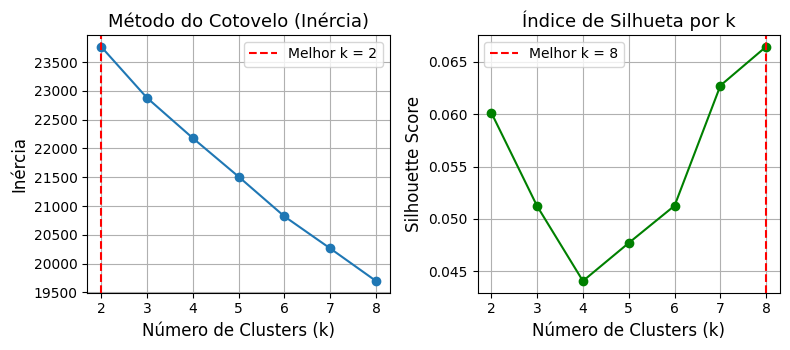

In [122]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3.6))

# Tamanho da fonte
fs_ticks = 10
fs_labels = 12
fs_title = 13

# Cotovelo
axs[0].plot(k_values, inercia, marker='o')
axs[0].axvline(x=melhor_k_cotovelo, color='red', linestyle='--', label=f'Melhor k = {melhor_k_cotovelo}')
axs[0].set_title('Método do Cotovelo (Inércia)', fontsize=fs_title)
axs[0].set_xlabel('Número de Clusters (k)', fontsize=fs_labels)
axs[0].set_ylabel('Inércia', fontsize=fs_labels)
axs[0].legend(fontsize=fs_ticks)
axs[0].set_xticks(k_values)
axs[0].tick_params(axis='both', labelsize=fs_ticks)
axs[0].grid(True)

# Silhueta
axs[1].plot(k_values, silhouette, marker='o', color='green')
axs[1].axvline(x=melhor_k_silhueta, color='red', linestyle='--', label=f'Melhor k = {melhor_k_silhueta}')
axs[1].set_title('Índice de Silhueta por k', fontsize=fs_title)
axs[1].set_xlabel('Número de Clusters (k)', fontsize=fs_labels)
axs[1].set_ylabel('Silhouette Score', fontsize=fs_labels)
axs[1].legend(fontsize=fs_ticks)
axs[1].set_xticks(k_values)
axs[1].tick_params(axis='both', labelsize=fs_ticks)
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [123]:
# PCA (Análise de Componentes Principais)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [124]:
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]


#### Influência de Variáveis sobre o PCA

In [125]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['Componente 1', 'Componente 2'],
    index=X.columns)

loadings['Magnitude'] = loadings.apply(lambda x: np.sqrt(x['Componente 1']**2 + x['Componente 2']**2), axis=1)
loadings = loadings.sort_values(by='Magnitude', ascending=False)
loadings = loadings[loadings['Magnitude'] > 0.1]        
loadings = loadings.reset_index()
loadings.columns = ['Variável', 'Componente 1', 'Componente 2', 'Magnitude']
loadings

,Variável,Componente 1,Componente 2,Magnitude
0,alcool_fim_semana,0.071233,0.456309,0.461836
1,alcool_dias_uteis,0.095649,0.428520,0.439065
2,escolaridade_mae,-0.400225,0.119705,0.417743
3,escolaridade_pai,-0.371364,0.131470,0.393949
4,genero_Mulher,0.026193,-0.327284,0.328330
5,frequencia_saidas,0.052001,0.296925,0.301444
6,interesse_ensino_superior,-0.237433,-0.155832,0.284004
7,reprovacoes,0.219496,0.158483,0.270732
8,profissao_mae_Professor(a),-0.241926,0.112297,0.266719
9,profissao_mae_Outra profissão,0.203137,-0.165994,0.262333


In [126]:
cores = aplicar_estilo_visual(paleta=cor_paleta,n =10)[::-1]

In [127]:
top_loadings = loadings.head(10)


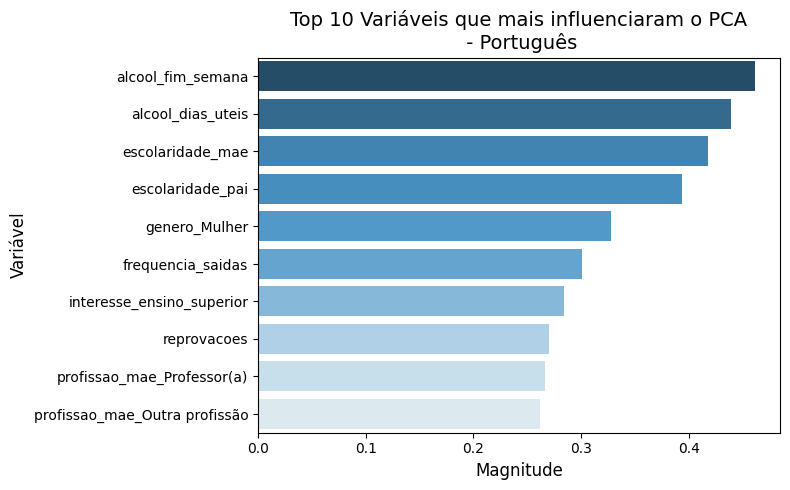

In [128]:
plt.figure(figsize=(8, 5))
sns.barplot(x='Magnitude', y='Variável', data=top_loadings, palette=cores)

plt.title('Top 10 Variáveis que mais influenciaram o PCA\n - Português', fontsize=14)
plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('Variável', fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


#### **k=2**

In [129]:
df['cluster_k2'] = KMeans(n_clusters=melhor_k_cotovelo, random_state=42).fit_predict(X_pca)

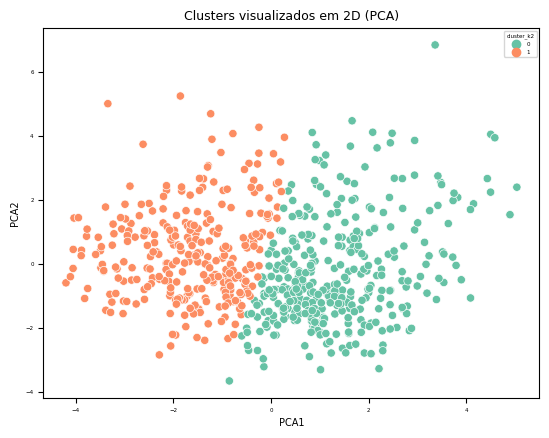

In [130]:
df['cluster_k2'] = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

# 5. Visualiza os clusters  
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster_k2', data=df, palette='Set2')
plt.title('Clusters visualizados em 2D (PCA)')
plt.show()


In [131]:
df.groupby('cluster_k2')[['nota_final', 'faltas']].describe()


nota_final                                                    \
                count       mean       std  min   25%   50%   75%   max   
cluster_k2                                                                
0               359.0  11.089136  3.312052  0.0  10.0  11.0  13.0  19.0   
1               290.0  12.917241  2.821086  0.0  11.0  13.0  15.0  19.0   

           faltas                                                
            count      mean       std  min  25%  50%  75%   max  
cluster_k2                                                       
0           359.0  3.612813  4.414672  0.0  0.0  2.0  6.0  26.0  
1           290.0  3.717241  4.913372  0.0  0.0  2.0  6.0  32.0

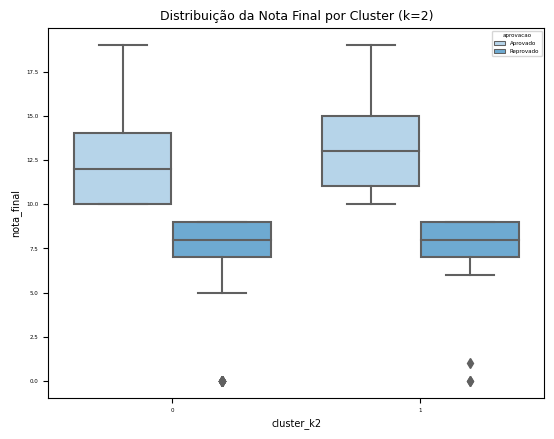

In [132]:
cor_paleta = aplicar_estilo_visual('azul')

# Gráfico de dispersão
sns.boxplot(data=df, x='cluster_k2', y='nota_final', hue='aprovacao',palette=cor_paleta)
plt.title('Distribuição da Nota Final por Cluster (k=2)')
plt.show()


#### **k=8**

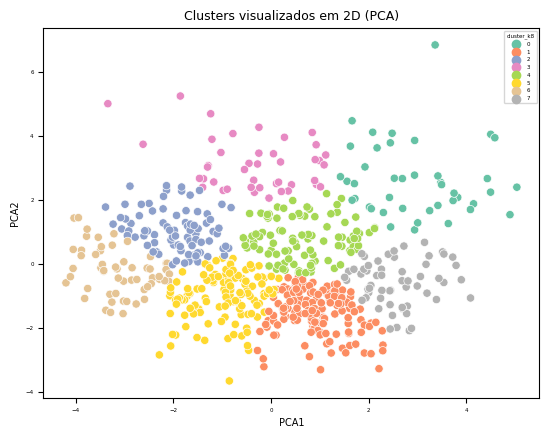

In [133]:

df['cluster_k8'] = KMeans(n_clusters=melhor_k_silhueta, random_state=42).fit_predict(X_pca)
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster_k8', data=df, palette='Set2')
plt.title('Clusters visualizados em 2D (PCA)')
plt.show()


In [134]:
df.groupby('cluster_k8')[['nota_final', 'faltas']].describe()


nota_final                                                      \
                count       mean       std  min    25%   50%    75%   max   
cluster_k8                                                                  
0                42.0   8.619048  3.554128  0.0   8.25  10.0  11.00  14.0   
1               148.0  12.500000  2.709269  0.0  11.00  13.0  14.00  19.0   
2                84.0  13.190476  2.889433  0.0  11.75  13.0  15.25  19.0   
3                42.0  10.833333  3.075606  1.0   9.00  11.0  12.00  17.0   
4                95.0  10.978947  2.817041  0.0  10.00  11.0  12.50  18.0   
5               124.0  12.677419  2.614992  0.0  11.00  13.0  14.00  18.0   
6                56.0  14.107143  2.317354  8.0  13.00  14.0  16.00  18.0   
7                58.0   9.431034  3.574334  0.0   8.25  10.0  11.00  15.0   

           faltas                                                  
            count      mean       std  min  25%  50%    75%   max  
cluster_k8                                                         
0            42.0  6.452381  6.081569  0.0  2.0  4.5   9.75  26.0  
1           148.0  2.824324  3.686187  0.0  0.0  2.0   4.00  21.0  
2            84.0  3.404762  4.599945  0.0  0.0  2.0   6.00  30.0  
3            42.0  7.261905  5.691498  0.0  2.5  8.0  10.75  22.0  
4            95.0  4.684211  5.715345  0.0  0.0  4.0   7.00  32.0  
5           124.0  2.895161  3.946427  0.0  0.0  2.0   4.00  18.0  
6            56.0  2.178571  2.420422  0.0  0.0  2.0   4.00  10.0  
7            58.0  2.913793  3.604502  0.0  0.0  2.0   4.00  14.0

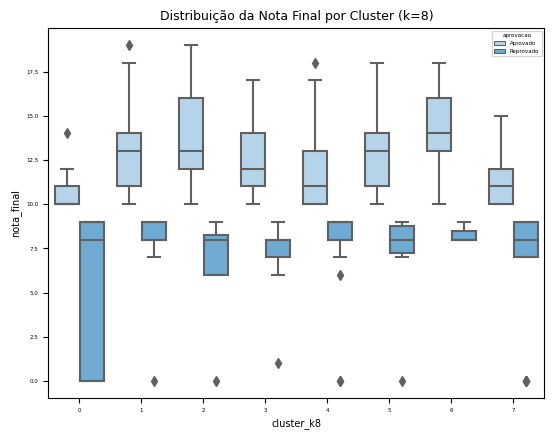

In [135]:
sns.boxplot(data=df, x='cluster_k8', y='nota_final', hue='aprovacao',palette=cor_paleta)
plt.title('Distribuição da Nota Final por Cluster (k=8)')
plt.show()